In [0]:
# libraries you will need for following through this notebook.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import multivariate_normal

In [0]:
# The following is code for uploading a file to the colab.research.google 
# environment.

# library for uploading files
from google.colab import files 

def upload_files():
    # initiates the upload - follow the dialogues that appear
    uploaded = files.upload()

    # verify the upload
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

    # uploaded files need to be written to file to interact with them
    # as part of a file system
    for filename in uploaded.keys():
        with open(filename, 'wb') as f:
            f.write(uploaded[filename])

In [0]:
# you need to upload two data files for this notebook to work:
# datasets-medical.csv
# mushrooms.csv
# both will be supplied via the remote drive
upload_files()

In [0]:
medical_df = pd.read_csv("datasets-medical.csv")
mushroom_df = pd.read_csv("mushrooms.csv")

# Clustering Examples

# K-Means

sklearn has a convient function for doing k-means clustering:

http://scikit-learn.org/stable/modules/clustering.html#k-means

Here I will show you k-means using a subset of the medical data. medical_df contains
the data. The first thing we need to do is transform the data so that clustering makes sense. The following is just EDA so you see what the dataset contains:

In [0]:
medical_df.head()

,id,fitness_level,age,weight,height,region,dietary_level,has_kids_under_18,sick_days,activities
0,1,1,60,77.11,1.69,3,2,0,67,NaN
1,2,2,23,61.68,1.64,0,0,0,16,"walking,running"
2,3,1,22,60.23,1.65,0,1,0,12,"running,biking"
3,4,2,32,72.48,1.74,1,2,1,62,"walking,running"
4,5,1,31,54.21,1.61,0,0,1,73,"walking,biking,athletic"


In [0]:
medical_df.activities.value_counts()

walking,running                    157
walking,biking                     111
walking,running,biking              81
walking                             67
running,biking                      58
walking,running,athletic            39
walking,biking,athletic             36
running,biking,athletic             34
walking,athletic                    30
biking,athletic                     20
running,athletic                    18
walking,extreme sports              15
running,biking,extreme sports       12
walking,biking,extreme sports       10
walking,athletic,extreme sports      8
running                              7
running,athletic,extreme sports      7
walking,running,extreme sports       6
biking,extreme sports                6
biking,athletic,extreme sports       5
running,extreme sports               5
athletic,extreme sports              4
biking                               3
athletic                             2
Name: activities, dtype: int64

In [0]:
medical_df.region.value_counts()

0    315
4    251
3    169
1    138
2    127
Name: region, dtype: int64

In [0]:
medical_df.has_kids_under_18.value_counts()

0    615
1    385
Name: has_kids_under_18, dtype: int64

In [0]:
medical_df.sick_days.describe()

count    1000.00000
mean       64.28600
std        47.75616
min         0.00000
25%        25.00000
50%        56.00000
75%        93.00000
max       240.00000
Name: sick_days, dtype: float64

In [0]:
medical_df.columns

Index(['id', 'fitness_level', 'age', 'weight', 'height', 'region',
       'dietary_level', 'has_kids_under_18', 'sick_days', 'activities'],
      dtype='object')

Next we transform the data. You will notice that in the end we actually only use a few of the features. This is because those are the features that cluster nicely. In practice you wouldn't know that though, so I left in how I would prepare the whole dataset as an example of what data transformations could look like.

A new function you will see is get_dummies():

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

Get_dummies prepares categorical columns for input to ML/Data mining algorithms. e.g.

A column called color with values in {red, blue, yellow} would be transformed to be three columns:

*    color_red: 1 if color=red, 0 otherwise
*    color_blue: 1 if color=blue, 0 otherwise
*    color_yellow: 1 if color=yellow, 0 otherwise


In [0]:
# I use a function create binary columns out of the activity column
# This is not used in the final clustering, but is an example of one way
# of dealing with a column like activities.
activities_names = ["does_walking",
                    "does_running",
                    "does_atheletics",
                    "does_extreme_sports"]

def process_activities_column(activity_str):
    if pd.isna(activity_str):
        activity_list = []
    else:
        activity_list = activity_str.split(",")
    return pd.Series({activities_names[0]: 1 if "walking" in activity_list else 0,
                      activities_names[1]: 1 if "running" in activity_list else 0,
                      activities_names[2]: 1 if "athletic" in activity_list else 0,
                      activities_names[3]: 1 if "extreme sports" in activity_list else 0})

med_df_clean = medical_df.merge(medical_df.activities.apply(process_activities_column),
                                left_index=True,
                                right_index=True)

# Next I deal with the categorical variables
fitness_names = ["fitness_0", "fitness_1", "fitness_2", "fitness_3", "fitness_4"]
med_df_clean[fitness_names] = pd.get_dummies(med_df_clean.fitness_level)

diet_names = ["diet_0", "diet_1", "diet_2", "diet_3", "diet_4"]
med_df_clean[diet_names] = pd.get_dummies(med_df_clean.dietary_level)

region_names = ["region_0", "region_1", "region_2", "region_3", "region_4"]
med_df_clean[region_names] = pd.get_dummies(med_df_clean.region)

# This is an important domain level features. BMI is only found by thinking about
# what might be important in the dataset.
med_df_clean["bmi"] = med_df_clean.weight / (med_df_clean.height * med_df_clean.height)

# select column subset. I know what subset is important ahead of time - in practice
# you will have to try different subsets you think ahead of time might be useful together
# OR look at covariance and see what columns are dependant
select_columns = ["age", "bmi"] + fitness_names + diet_names
med_df_clean = med_df_clean.loc[:, select_columns]
med_df_clean.head()


,age,bmi,fitness_0,fitness_1,fitness_2,fitness_3,fitness_4,diet_0,diet_1,diet_2,diet_3,diet_4
0,60,26.998354,0,1,0,0,0,0,0,1,0,0
1,23,22.932778,0,0,1,0,0,1,0,0,0,0
2,22,22.123049,0,1,0,0,0,0,1,0,0,0
3,32,23.939754,0,0,1,0,0,0,0,1,0,0
4,31,20.913545,0,1,0,0,0,1,0,0,0,0


We are ready to actually do the clustering. The parameters I use here are:

*    n_clusters: The k in kmeans. The number of clusters to look for
*    n_init: The number of times to randomly initialize and search for clusters. Higher numbers mean better results, but longer runtime.


In [0]:
my_kmeans_obj = KMeans(n_clusters=4, n_init=1000)
kmeans_med = my_kmeans_obj.fit(med_df_clean)
# cluster centers show the center points of each cluster.
# Optional exercise: What do these cluster centers mean? What can you
# reason about what sub-populations the 4 groups represent?
print(kmeans_med.cluster_centers_)

[[ 3.27319588e+01  3.07882936e+01  4.02061856e-01  5.05154639e-01
   8.24742268e-02  1.03092784e-02 -4.16333634e-17  5.15463918e-01
   3.50515464e-01  1.23711340e-01  3.05311332e-16  1.03092784e-02]
 [ 6.45913978e+01  2.45421941e+01  4.83870968e-01  3.60215054e-01
   1.55913978e-01  3.60822483e-16  1.59594560e-16  5.91397849e-02
   2.31182796e-01  3.11827957e-01  2.25806452e-01  1.72043011e-01]
 [ 2.14055300e+01  2.29047119e+01  1.54377880e-01  1.19815668e-01
   3.57142857e-01  2.41935484e-01  1.26728111e-01  2.60368664e-01
   3.87096774e-01  2.39631336e-01  1.10599078e-01  2.30414747e-03]
 [ 2.95901060e+01  2.27554834e+01  1.73144876e-01  3.00353357e-01
   3.35689046e-01  1.87279152e-01  3.53356890e-03  1.44876325e-01
   2.50883392e-01  2.68551237e-01  2.50883392e-01  8.48056537e-02]]


In [0]:
kmeans_med.labels_

array([1, 2, 2, 3, 3, 0, 2, 3, 0, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3, 2,
       2, 1, 2, 3, 3, 1, 2, 3, 3, 2, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 0, 1, 1, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 3, 2, 1, 0, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 0, 2, 3, 3, 0, 0, 2, 1, 3, 2, 1, 3, 2, 3, 3,
       1, 2, 1, 0, 3, 2, 0, 2, 0, 2, 2, 3, 3, 1, 0, 0, 3, 0, 0, 2, 1, 2,
       2, 2, 3, 2, 3, 0, 3, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 2, 1, 3, 1, 2,
       0, 3, 0, 3, 0, 2, 1, 0, 3, 3, 1, 2, 2, 2, 1, 3, 2, 2, 2, 2, 1, 3,
       2, 3, 3, 0, 2, 1, 2, 2, 0, 0, 1, 3, 2, 2, 1, 1, 3, 2, 3, 2, 3, 3,
       3, 2, 2, 0, 3, 1, 3, 3, 2, 3, 2, 3, 1, 2, 0, 2, 1, 2, 1, 2, 3, 0,
       2, 0, 3, 3, 3, 2, 3, 3, 2, 1, 2, 3, 0, 1, 3, 2, 1, 2, 2, 2, 3, 3,
       1, 1, 2, 3, 3, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 3, 2, 2, 2, 0, 1, 0, 1, 1, 3, 3, 1, 1, 2,
       2, 1, 3, 2, 3, 2, 3, 0, 2, 3, 2, 2, 3, 3, 2, 1, 3, 0, 2, 2, 2, 3,
       3, 1, 3, 1, 3, 1, 2, 2, 1, 2, 2, 3, 2, 1, 3,

In [0]:
# Add assigned clusters as a column to our data
# This makes it easier to graph
med_df_clustered = med_df_clean.copy()
med_df_clustered["cluster"] = pd.Series(kmeans_med.labels_)
med_df_clustered.head()

,age,bmi,fitness_0,fitness_1,fitness_2,fitness_3,fitness_4,diet_0,diet_1,diet_2,diet_3,diet_4,cluster
0,60,26.998354,0,1,0,0,0,0,0,1,0,0,1
1,23,22.932778,0,0,1,0,0,1,0,0,0,0,2
2,22,22.123049,0,1,0,0,0,0,1,0,0,0,2
3,32,23.939754,0,0,1,0,0,0,0,1,0,0,3
4,31,20.913545,0,1,0,0,0,1,0,0,0,0,3


Let's plot the data according to age and BMI. Luckily, this data is roughly separable from those features alone. In practice, you will often need to use dimensionality reduction as well to visualize your data.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

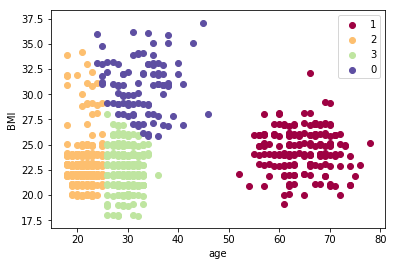

In [0]:
# Add assigned clusters as a column to our data
# This makes it easier to graph
med_df_clustered = med_df_clean.copy()
med_df_clustered["cluster"] = pd.Series(kmeans_med.labels_)

# Grab the cluster labels and generate a color for each one. Since we know
# that there are 4 clusters we could specify the colours manually, but this solution
# scales automatically with k.
unique_labels = med_df_clustered.cluster.unique()
colours = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# The scatter plot. For each cluster I filter the data and plot just that with the
# corresponding colour. 
plt.figure()
scatters = []
for cluster_id, colour in zip(unique_labels, colours):
    med_df_cluster = med_df_clustered.loc[med_df_clustered.cluster == cluster_id, ["age", "bmi"]]
    scatters.append(plt.scatter(x=med_df_cluster.age ,y=med_df_cluster.bmi, c=colour))
plt.legend((scatters[0], scatters[1], scatters[2], scatters[3]), unique_labels)
plt.ylabel("BMI")
plt.xlabel("age")
plt.show()

# TODO: labels and legend etc.


# DBSCAN

sklearn method for DBSCAN clustering:

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

Remember, density based clustering is great when you don't know K ahead of time and you have points that are outliers. Let's generate some synthetic data for this example:

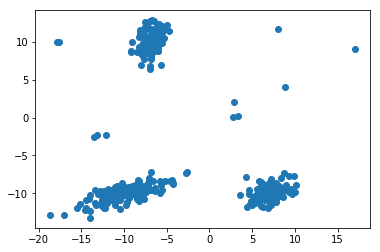

In [0]:
# fix the seed for reporducibility
np.random.seed(1338)

# This generates data that natually falls into 3 clusters with a bunch of little
# outliers scattered around. Look up multivariate normal distributions for more
# information on how the covariance matrices affect the generated data. The 
# take-away is they affect the shape of the scattered data.
cluster_1 = multivariate_normal.rvs(mean=(-7, 10), cov=np.array([[1, 0.6], [0.6, 2]]), size=100)
cluster_2 = multivariate_normal.rvs(mean=(7, -10), cov=np.array([[2, 0.6], [0.6, 1]]), size=100)
cluster_3 = multivariate_normal.rvs(mean=(-10, -10), cov=np.array([[7, 2], [2, 1]]), size=150)
noise_1 = multivariate_normal.rvs(mean=(0, 0), cov=np.array([[10, 2], [2, 1]]), size=3)
noise_2 = multivariate_normal.rvs(mean=(-15, -3), cov=np.array([[10, 3], [3, 1]]), size=3)
noise_3 = multivariate_normal.rvs(mean=(-18, 10), cov=np.array([[10, 3], [3, 1]]), size=2)
noise_4 = multivariate_normal.rvs(mean=(8, 11), cov=np.array([[12, 2], [2, 12]]), size=3)
concat_data = np.concatenate((cluster_1, cluster_2, cluster_3, noise_1, noise_2, noise_3, noise_4), axis=0)
data_df = pd.DataFrame(concat_data, columns=["X", "Y"])
data_df = data_df.sample(frac=1).reset_index(drop=True)

# plot the data
plt.figure()
plt.scatter(x=data_df.X, y=data_df.Y)
plt.show()

In [0]:
# The actual clustering. I listed all the parameters here so you can see them.
# The one I altered is eps. Play around with it to see how the clusters change.
# eps is the threshold in terms of your distance metric that data points
# should be considered a part of the same cluster at.

db_scan = DBSCAN(eps=5,
                 min_samples=5,
                 metric="euclidean",
                 metric_params=None,
                 algorithm="auto",
                 leaf_size=30,
                 p=None,
                 n_jobs=1)
db_scan = db_scan.fit(data_df)

data_df["cluster"] = pd.Series(db_scan.labels_)

data_df.head()

,X,Y,cluster
0,-7.707882,7.771783,0
1,-7.721503,11.579987,0
2,-8.285416,-9.111703,1
3,5.169362,-10.477183,2
4,-10.532815,-10.874397,1


In [0]:
data_df.loc[data_df.cluster==-1,:]

,X,Y,cluster
57,2.771469,0.062541,-1
99,-17.874564,9.920510,-1
122,-13.149171,-2.354347,-1
128,7.981244,11.623464,-1
159,2.829525,1.993207,-1
160,-12.158548,-2.286528,-1
197,8.877615,4.049561,-1
280,3.357260,0.213518,-1
283,-17.651606,9.901424,-1
287,17.009808,9.029205,-1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

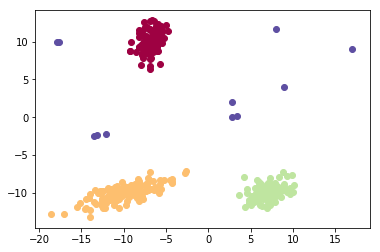

In [0]:
# plot data again

unique_labels = data_df.cluster.unique()
colours = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure()
for cluster_id, colour in zip(unique_labels, colours):
    data_df_cluster = data_df.loc[data_df.cluster == cluster_id, ["X", "Y"]]
    plt.scatter(x=data_df_cluster.X ,y=data_df_cluster.Y, c=colour)
plt.show()


# Hierarchical clustering

sklearn has a function for the same algorithm:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

I used scipy though because scipy has methods for visualize the actual hierarchy (sklearn's implemention produces a 'flat' clustering):

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

Linkage is used to compute the clustering and dendogram is used to plot it. Dendogram uses matplotlib so plots are easy to modify.


In [0]:
# We will use the data from the DBSCAN example
# this example will only work if called directly after the DBSCAN example code!!
hier_data_df = data_df.copy()
hier_data_df.head()

,X,Y,cluster
0,-7.707882,7.771783,0
1,-7.721503,11.579987,0
2,-8.285416,-9.111703,1
3,5.169362,-10.477183,2
4,-10.532815,-10.874397,1


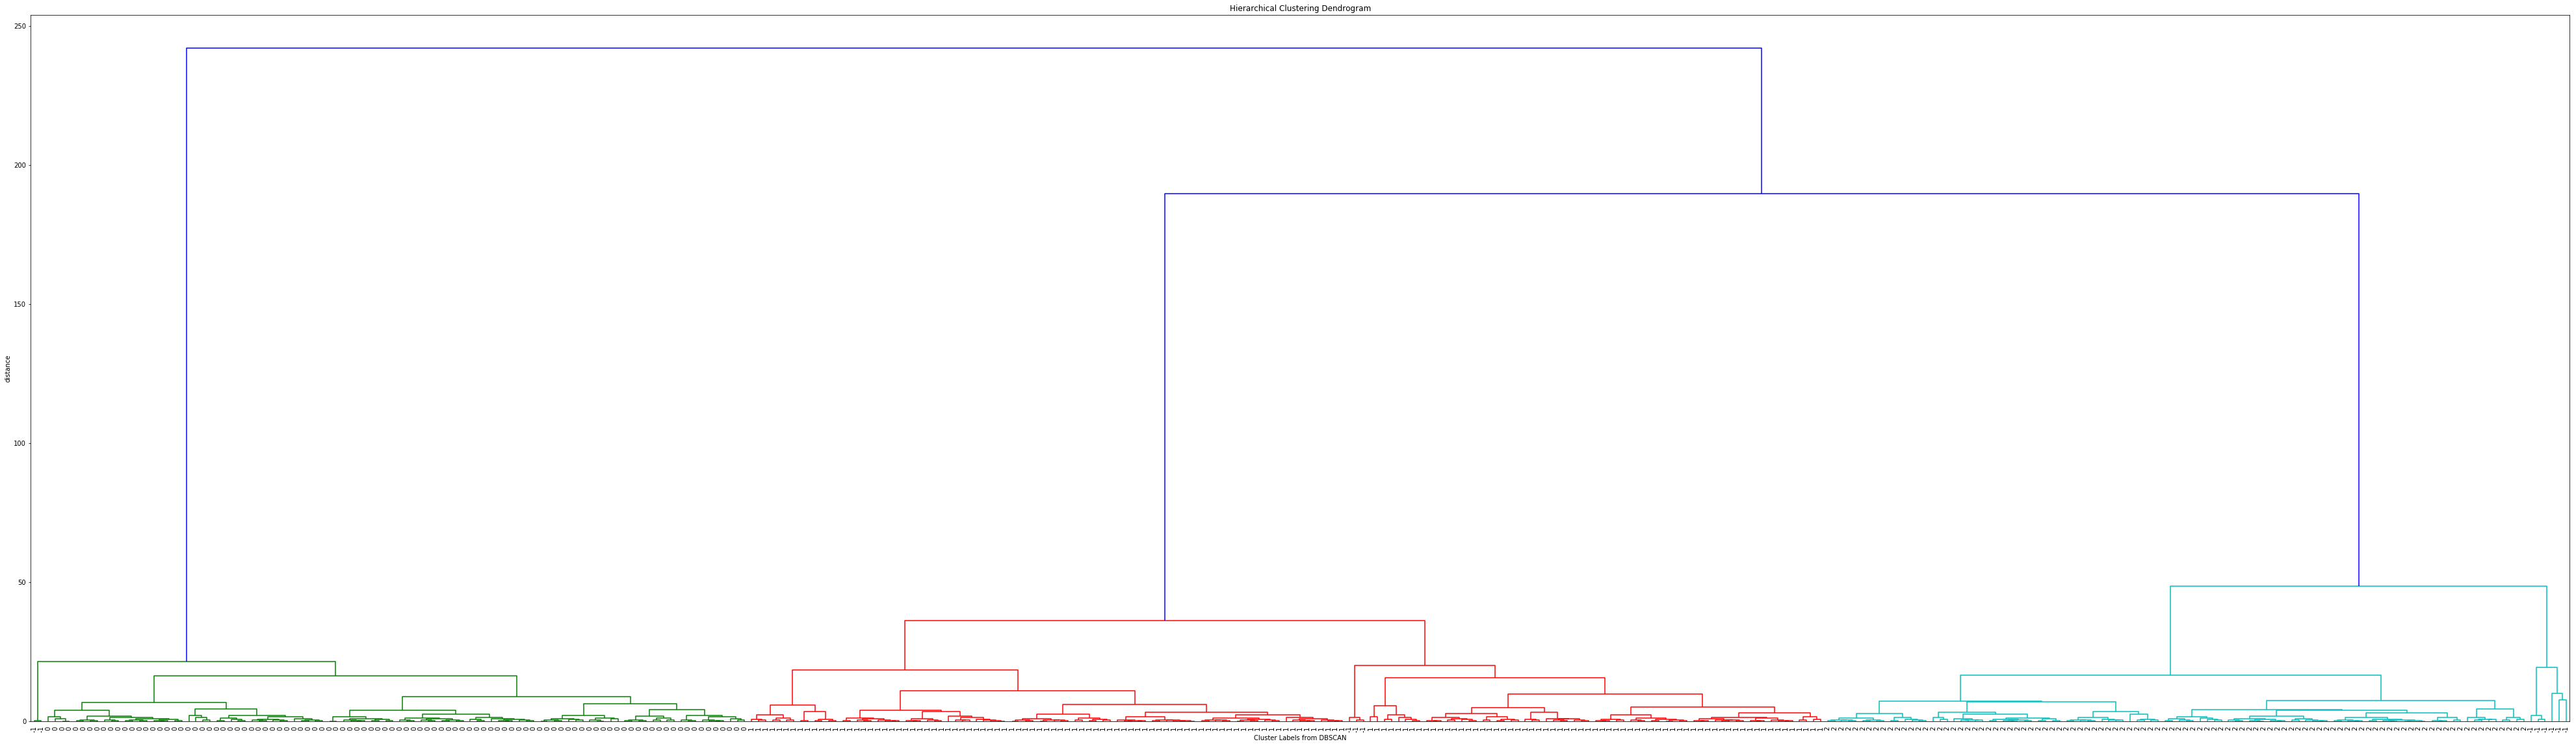

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(hier_data_df.loc[:, ["X", "Y"]], 'ward')
# this figure needs to be huge so the labels are readable
plt.figure(figsize=(70, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Labels from DBSCAN')
plt.ylabel('distance')

# We use the leaf_label_func argument to label the leaves with the cluster
# labels produced by dbscan. You can use this to verify the "correctness" of
# the hierarchical cluster and observe anything interesting.
#
# Use the truncate_mode="lastp" to make it more readble
# this aggregates leaf nodes that are close to each other
# This doesn't work with our leaf_label_func though, so it is
# one or the other
dendrogram(
    linkage_matrix,
    leaf_font_size=10.,
    leaf_label_func=lambda x: str(hier_data_df.loc[x, "cluster"]))
plt.show()

# Dimensionality Reduction - PCA and TSNE

Here are some examples about using dimensionality reduction to visualize data that is more than 3 dimensions along with some sklearn links. Hopefully you can see how dimensionality reduction can be useful for clustering!

PCA:
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn-decomposition-pca

fit_transform computes the new space and projects the old data on to it (data is copied):
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform

t-SNE:
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

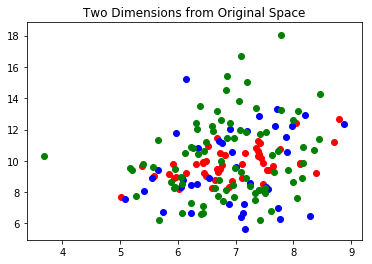

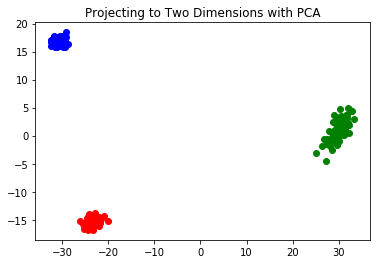

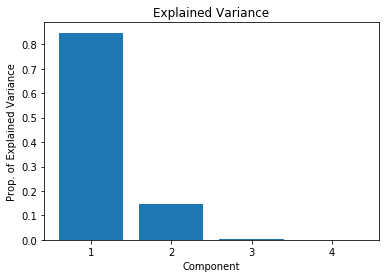

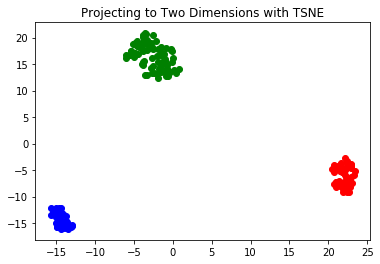

In [3]:
# We generate normal data again
# This time the data is in 4 dimensions

np.random.seed(1337)
cov_mat=np.array([[1, 0.6, 0.6, 0.6],
                  [0.6, 1, 0.6, 0.6],
                  [0.6, 0.6, 1, 0.6],
                  [0.6, 0.6, 0.6, 1]])
cluster_1 = multivariate_normal.rvs(mean=(7, 10, 7, 12), cov=cov_mat.copy(), size=50)
cluster_1_df = pd.DataFrame(cluster_1, columns=["X1", "X2", "X3", "X4"])
cluster_1_df["cluster"] = 1

cov_mat[1][1] = 6
cluster_2 = multivariate_normal.rvs(mean=(7, 10, 30, -12), cov=cov_mat.copy(), size=40)
cluster_2_df = pd.DataFrame(cluster_2, columns=["X1", "X2", "X3", "X4"])
cluster_2_df["cluster"] = 2

cov_mat[3][3] = 7
cluster_3 = multivariate_normal.rvs(mean=(7, 10, -30, -30), cov=cov_mat.copy(), size=80)
cluster_3_df = pd.DataFrame(cluster_3, columns=["X1", "X2", "X3", "X4"])
cluster_3_df["cluster"] = 3

data_df = pd.concat((cluster_1_df, cluster_2_df, cluster_3_df), axis=0)
data_df = data_df.sample(frac=1).reset_index(drop=True)

# first we just show two dimensions from the original space
# the clusters are not obvious are they?
plt.figure()
colours=["red", "blue", "green"]
clusters=[1, 2, 3]
for cluster_id in clusters:
    cluster_data = data_df.loc[data_df["cluster"] == cluster_id, ["X1", "X2", "X3", "X4"]]
    plt.scatter(cluster_data.X1, cluster_data.X2, c=colours[cluster_id-1])
plt.title("Two Dimensions from Original Space")
plt.show()

# next we perform PCA
# fit_transform both computes the new components and projects the
# original data onto the new space (copies)
# you can use n_components to specify the number of dimensions you want
# to use of the new space.
pca = PCA(n_components=2)
dim_data_np = pca.fit_transform(data_df.loc[:, ["X1", "X2", "X3", "X4"]])
dim_data_df = pd.DataFrame(dim_data_np, columns=["new_X1", "new_X2"])
dim_data_df["cluster"] = data_df.cluster

plt.figure()
colours=["red", "blue", "green"]
clusters=[1, 2, 3]
for cluster_id in clusters:
    cluster_data = dim_data_df.loc[dim_data_df["cluster"] == cluster_id, ["new_X1", "new_X2"]]
    plt.scatter(cluster_data.new_X1, cluster_data.new_X2, c=colours[cluster_id-1])
plt.title("Projecting to Two Dimensions with PCA")
plt.show()

pca = PCA(n_components=4)
pca.fit(data_df.loc[:, ["X1", "X2", "X3", "X4"]])
plt.figure()
plt.bar(["1","2","3","4"], pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Prop. of Explained Variance")
plt.title("Explained Variance")
plt.show()

# working with t-SNE is the same
# notice anything different about the clustering? What about the run time?
# If you have some extra time, try modifying the default parameters and see how
# they affect the shape of the projected data
tsne = TSNE(n_components=2)
dim_data_np = tsne.fit_transform(data_df.loc[:, ["X1", "X2", "X3", "X4"]])
dim_data_df = pd.DataFrame(dim_data_np, columns=["new_X1", "new_X2"])
dim_data_df["cluster"] = data_df.cluster

plt.figure()
colours=["red", "blue", "green"]
clusters=[1, 2, 3]
for cluster_id in clusters:
    cluster_data = dim_data_df.loc[dim_data_df["cluster"] == cluster_id, ["new_X1", "new_X2"]]
    plt.scatter(cluster_data.new_X1, cluster_data.new_X2, c=colours[cluster_id-1])
plt.title("Projecting to Two Dimensions with TSNE")
plt.show()


Now for a more in depth t-SNE example. t-SNE can be a little slow but is very powerful algorithm for identifying clusters and visualizing data in a high dimensional space.

Let's examine the mushroom dataset you uploaded earlier. More info can be found here:

https://www.kaggle.com/uciml/mushroom-classification/version/1

The "class" variable tells you whether the mushroom is edible or poisonous. Let's remove it and then look at the other features. Can we visualize the other features in a way that is meaningful to the class variable?

Discussion: We have class labels. You are probably thinking that that makes it a supervised learning problem. What roles can unsupervised techniques play in a supervised classification problem?

In [7]:
mushroom_class = mushroom_df["class"]
mushroom_df = mushroom_df.iloc[:, 1:]
mushroom_df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


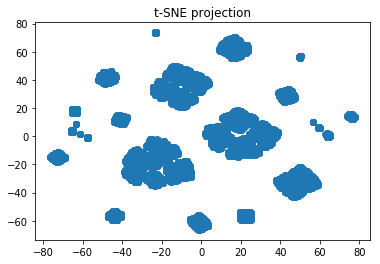

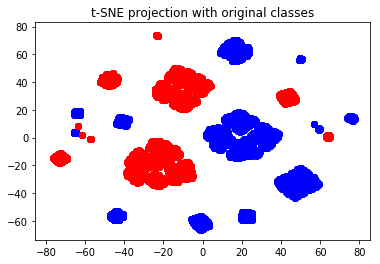

In [8]:
# prepare data. Take a look at mushroom_dummy if you are interested how
# get_dummies deals with the categorical labels
mushroom_dummy = pd.get_dummies(mushroom_df)

# this is the projection. Note using it looks very similar to PCA.
# NOTE: This take several minutes to run - it is slow!
tsne = TSNE(n_components=2)
dim_data_np = tsne.fit_transform(mushroom_dummy)
dim_data_df = pd.DataFrame(dim_data_np, columns=["new_X1", "new_X2"])

# plot the projection
plt.figure()
plt.scatter(dim_data_df.new_X1, dim_data_df.new_X2)
plt.title("t-SNE projection")
plt.show()

# plot the projection with classes as colours
dim_data_df["class"] = mushroom_class
plt.figure()
colours={'e': "blue", 'p':"red"}
classes=['e', 'p']
for class_id in classes:
    class_data = dim_data_df.loc[dim_data_df["class"] == class_id, ["new_X1", "new_X2"]]
    plt.scatter(class_data.new_X1, class_data.new_X2, c=colours[class_id])
plt.title("t-SNE projection with original classes")
plt.show()

# Optional discussion/exercise: Where would you go from here? What utility does
# the second plot serve?


Optional follow up: You can probably identify some natural cluster now. What characteristics that determine edible vs poisonous are there? How would you use this to come up with some predictive rules? What domain knowledge did this task uncover about mushrooms?

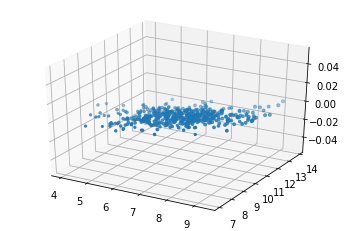

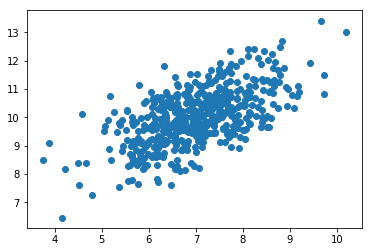

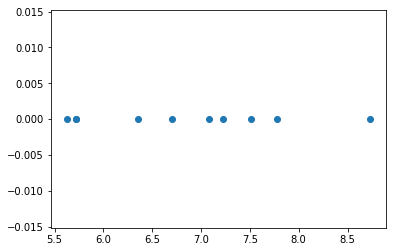

In [9]:
from mpl_toolkits.mplot3d import Axes3D
cov_mat=np.array([[1, 0.6, 0.6],
                  [0.6, 1, 0.6],
                  [0.6, 0.6, 1]])
cluster_1 = multivariate_normal.rvs(mean=(7, 10, 7), cov=cov_mat.copy(), size=500)
cluster_1_df = pd.DataFrame(cluster_1, columns=["X1", "X2", "X3"])
cluster_1_df["cluster"] = 1

plt.figure()
plt.subplot(111, projection="3d")
plt.scatter(cluster_1_df.X1, cluster_1_df.X2, cluster_1_df.X3)
plt.show()

cov_mat=np.array([[1, 0.6],
                  [0.6, 1]])
cluster_1 = multivariate_normal.rvs(mean=(7, 10), cov=cov_mat.copy(), size=500)
cluster_1_df = pd.DataFrame(cluster_1, columns=["X1", "X2"])
cluster_1_df["cluster"] = 1

plt.figure()
plt.scatter(cluster_1_df.X1, cluster_1_df.X2)
plt.show()

cov_mat=np.array([[1]])
cluster_1 = multivariate_normal.rvs(mean=(7), cov=cov_mat.copy(), size=10)
cluster_1_df = pd.DataFrame(cluster_1, columns=["X1"])
cluster_1_df["cluster"] = 1

plt.figure()
plt.scatter(cluster_1_df.X1, np.zeros(cluster_1_df.shape[0]))
plt.show()
